In [3]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [4]:
import functools
import jax
import os
import pandas as pd
import mlflow
import pickle
import spot

from datetime import datetime
from jax import numpy as jnp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output
import mediapy

import brax

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import corallab_stl
import corallab_stl.expression_jax2 as stl

# tasks
from task_aware_skill_composition.brax.tasks import get_task
from task_aware_skill_composition.brax.utils import (
    make_cmdp,
    make_shaped_reward_mdp,
    make_shaped_reward_mdp2,
    make_reward_machine_mdp,
    make_aut_goal_mdp,
    make_aut_goal_cmdp
)

mlflow.set_tracking_uri(f"file:///home/tassos/.local/share/mlflow")
# mlflow.set_experiment("proj2-final-comparison")
mlflow.set_experiment("proj2-main-algorithm-modification")

2025-01-08 13:53:14.835139: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Experiment: artifact_location='file:///home/tassos/.local/share/mlflow/201093555463172101', creation_time=1736277952779, experiment_id='201093555463172101', last_update_time=1736277952779, lifecycle_stage='active', name='proj2-main-algorithm-modification', tags={}>

# Defining Env/Task

In [30]:
backend = 'mjx'

# env = Car(backend=backend)
# env = Drone(backend=backend)
# env = Point(backend=backend)
# env = Doggo(backend=backend)

# env = envs.get_environment(env_name="reacher", backend=backend)
# env = AntMaze(backend=backend)

# task = get_task("simple_maze", "umaze_constraint")

# task = get_task("simple_maze", "true")
# task = get_task("simple_maze", "subgoal")
# task = get_task("simple_maze", "two_subgoals")
# task = get_task("simple_maze", "branching1")
# task = get_task("simple_maze", "obligation1")
task = get_task("simple_maze", "obligation2")

# task = get_task("simple_maze_3d", "true")
# task = get_task("simple_maze_3d", "subgoal")
# task = get_task("simple_maze_3d", "umaze_constraint")
# task = get_task("simple_maze_3d", "branching1")

# task = get_task("ant_maze", "true")
# task = get_task("ant_maze", "subgoal")
# task = get_task("ant_maze", "two_subgoals")
# task = get_task("ant_maze", "obligation1")
# task = get_task("ant_maze", "branching1")
# task = get_task("ant_maze", "umaze_constraint")
# task = get_task("ant_maze", "center_constraint")

# task = get_task("ur5e", "reach")

# task = get_task("point", "one_goal")
# task = get_task("ant_maze", "true")
# task = get_task("simple_maze", "branching2")
# task = get_task("simple_maze", "subgoal")
# task = get_task("simple_maze_3d", "true")
# task = get_task("hopper", "straight")
# task = get_task("xy_point", "diagonal1")
# task = get_task("ant", "straight_seq")

env = task.env

spec = task.lo_spec
spec_tag = type(task).__name__
env_tag = type(env).__name__

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [31]:
options = task.get_options()

up [0. 1.]
right [1. 0.]
left [-1.  0.]
down [ 0. -1.]


In [32]:
# env = SafetyHopperVelocityEnv(backend="mjx")
# spec = stl.STLPredicate(stl.Var(name="obs", dim=env.observation_size), lambda s: 999, lower_bound=0.0)
# spec_tag = "SafeVelocity"
# env_tag = "Hopper"

# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

In [33]:
print(spec_tag)
print(spec)
print(env.observation_size)
print(env.action_size)
alg_suffix = ""

SimpleMazeObligationConstraint2
6
2


## Making the Env Automaton Wrapped

Full Observation Size:  9
Q Input Size:  6
State Dim:  4
Goal Dim:  2


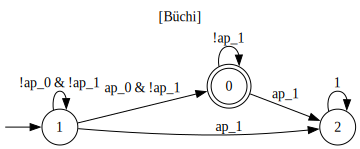

In [34]:
# from task_aware_skill_composition.brax.envs.wrappers.automaton_wrapper import AutomatonWrapper, AutomatonGoalConditionedWrapper
# from task_aware_skill_composition.brax.envs.wrappers.automaton_transition_rewards_wrapper import AutomatonTransitionRewardsWrapper
# from task_aware_skill_composition.brax.envs.wrappers.automaton_cost_wrapper import AutomatonCostWrapper

# # cmdp = make_cmdp(task)
# # aut = cmdp.automaton.automaton
# # spot.minimize_obligation(cmdp.automaton.automaton)

mdp = make_aut_goal_cmdp(task)
print("Full Observation Size: ", mdp.full_observation_size)
print("Q Input Size: ", mdp.observation_size)
print("State Dim: ", mdp.state_dim)
print("Goal Dim: ", mdp.goal_indices.size)
# mdp.liveness_automaton
mdp.automaton.automaton
# aut.highlight_state(2, 1)
# aut.highlight_edge(4, 1)
# aut.highlight_edge(5, 1)
# aut.highlight_edge(7, 1)
# aut

In [35]:
{ q: spot.bdd_to_formula(x, mdp.automaton.bdd_dict) for q, x in mdp.out_conditions.items() }

{0: spot.formula("ap_0"), 1: spot.formula("ap_0")}

In [36]:
mdp.automaton_goal_array

Array([[12.,  4.],
       [12.,  4.],
       [ 0.,  0.]], dtype=float32)

In [37]:
# mdp.safety_exps[2].child.info

# Plotting Utils

In [38]:
# xdata, ydata = [], []
# times = [datetime.now()]

def progress_fn(num_steps, metrics, **kwargs):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)
    
    # df.loc[num_steps] = {
    #     "time": datetime.now(),
    #     "eval/episode_reward": metrics['eval/episode_reward'],
    #     "eval/episode_robustness": metrics['eval/episode_robustness'] if 'eval/episode_robustness' in metrics else None, 
    #     "training/specification_loss": metrics['training/specification_loss'] if 'training/specification_loss' in metrics else None, 
    # }

# Training

In [39]:
from task_aware_skill_composition.brax.agents.ppo import train as ppo
from task_aware_skill_composition.brax.agents.dscrl import train as dscrl
from task_aware_skill_composition.brax.agents.ppo_with_spec_rewards import train as ppo_spec
from task_aware_skill_composition.brax.agents.hsac import train as hsac

from task_aware_skill_composition.brax.agents.sac_lagrangian import train as sac_lagrangian

from task_aware_skill_composition.brax.agents.ddpg import train as ddpg
from task_aware_skill_composition.brax.agents.ddpg_lagrangian import train as ddpg_lagrangian

from task_aware_skill_composition.brax.agents.hdqn import train as hdqn
from task_aware_skill_composition.brax.agents.hdqn_her import train as hdqn_her
from task_aware_skill_composition.brax.agents.hdqn_automaton_her import train as hdqn_automaton_her
from task_aware_skill_composition.brax.agents.hdcqn_her import train as hdcqn_her
from task_aware_skill_composition.brax.agents.hdcqn_automaton_her import train as hdcqn_automaton_her

from task_aware_skill_composition.brax.agents.sac_her import train as sac_her
from task_aware_skill_composition.brax.agents.sac_her_lagrangian import train as sac_her_lagrangian

from task_aware_skill_composition.baselines.reward_machines.crm import train as crm



def training_run(run_id, env, seed, train_fn=ppo.train, progress_fn=progress_fn, hyperparameters={}, extras={}):
    hyperparameters = {
        **hyperparameters,
        "seed": seed,
    }

    mlflow.log_params(hyperparameters)

    train_fn = functools.partial(train_fn, **hyperparameters)
    
    make_inference_fn, params, _ = train_fn(
        environment=env,
        progress_fn=progress_fn,
        seed=seed,
        **extras
    )

    with mlflow.MlflowClient()._log_artifact_helper(run_id, f'policy_params') as tmp_path:
        model.save_params(tmp_path, params)

    return make_inference_fn, params

In [40]:
def train_for_all(envs, tasks, func, alg_tag):
    for env_name in envs:
        for task_name in tasks:
            task = get_task(env_name, task_name)

            spec = task.lo_spec
            spec_tag = type(task).__name__
            env_tag = type(task.env).__name__
            options = task.get_options()

            for seed in range(0, 1):
                with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
                    func(run, task, seed, options, spec)

## Training Policy with PPO

In [48]:
for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo.train,
            hyperparameters=task.ppo_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

KeyboardInterrupt: 

## Training with Hierarchical PPO

In [ ]:
from task_aware_skill_composition.brax.agents.ppo_option_critic import train as ppo_option_critic
from task_aware_skill_composition.hierarchy.state import OptionState

In [ ]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options

# def adapter(x):
#     return x[..., :-2]

options = load_hard_coded_xy_point_options()
# options = load_xy_point_options() # adapter=adapter)

In [ ]:
# mlflow.set_experiment("proj2-hierarchical-ppo")

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "H_PPO"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ppo_option_critic.train,
            hyperparameters=task.hppo_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

## Training with DDPG

In [16]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "DDPG"}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=ddpg.train,
            hyperparameters=task.sac_her_hps,
            extras={
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

TypeError: train() got an unexpected keyword argument 'unroll_length'

## Training with SAC

In [ ]:
for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": "SAC"}) as run:

        print(env_tag)
        print(spec_tag)
        print(alg_tag)

        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=sac.train,
            hyperparameters=task.sac_hps,
            extras={
                # "specification": spec,
                # "state_var": task.obs_var,
            }
        )

## Training with SAC+HER

In [70]:
sac_her_hps = {
    "num_timesteps": 4_000_000,
    "reward_scaling": 1,
    "num_evals": 50,
    "episode_length": 1000,
    "normalize_observations": True,
    "action_repeat": 1,
    "discounting": 0.99,
    # "learning_rate": 3e-4,
    "num_envs": 512,
    "batch_size": 256,
    # "unroll_length": 62,
    "max_devices_per_host": 1,
    "max_replay_size": 10000,
    # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
    "min_replay_size": 1000,
    "use_her": True,
}

In [71]:
alg_tag = "SAC_HER"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=sac_her.train,
            hyperparameters=sac_her_hps,
            extras={
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Num_prefill_actor_steps:  21
Logging for 0
Logging for 614400
Logging for 691200
Logging for 768000
Logging for 844800
Logging for 921600
Logging for 998400
Logging for 1075200
Logging for 1152000
Logging for 1228800
Logging for 1305600
Logging for 1382400
Logging for 1459200
Logging for 1536000
Logging for 1612800
Logging for 1689600
Logging for 1766400
Logging for 1843200
Logging for 1920000
Logging for 1996800
Logging for 2073600
Logging for 2150400
Logging for 2227200
Logging for 2304000
Logging for 2380800
Logging for 2457600
Logging for 2534400
Logging for 2611200
Logging for 2688000
Logging for 2764800
Logging for 2841600
Logging for 2918400
Logging for 2995200
Logging for 3072000
Logging for 3148800
Logging for 3225600
Logging for 3302400
Logging for 3379200
Logging for 3456000
Logging for 3532800
Logging for 3609600
Logging for 3686400
Logging for 3763200
Logging for 3840000
Logging for 3916800
Logging for 3993600
Logging for 4070400
Logging for 4147200
Logging for 4224000
Log

## Training with Hierarchical SAC+HER

In [ ]:
# hsac_hps = {
#     "num_timesteps": 10_000_000,
#     "reward_scaling": 1,
#     "num_evals": 50,
#     "episode_length": 1000,
#     "normalize_observations": True,
#     "action_repeat": 1,
#     "discounting": 0.99,
#     # "learning_rate": 3e-4,
#     "num_envs": 256,
#     "batch_size": 256,
#     "unroll_length": 62,
#     "multiplier_num_sgd_steps": 1,
#     "max_devices_per_host": 1,
#     "max_replay_size": 10000,
#     # 8192, the default, causes the error "TypeError: broadcast_in_dim shape must have every element be nonnegative, got (-2, 50)."
#     "min_replay_size": 1000,
#     "use_her": True,
# }

In [ ]:
from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options
from task_aware_skill_composition.hierarchy.ant.load import load_ant_options

def adapter(x):
    return x[..., 2:-2]

# options = load_hard_coded_xy_point_options()
options = load_ant_options(adapter=adapter)
# options = load_xy_point_options() # adapter=adapter)

In [ ]:
%%notify

alg_tag = "H_SAC" + alg_suffix

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hsac.train,
            hyperparameters=task.hsac_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

## Training with HDQN

In [ ]:
# from task_aware_skill_composition.hierarchy.xy_point.load import load_xy_point_options, load_hard_coded_xy_point_options
# from task_aware_skill_composition.hierarchy.ant.load import load_ant_options

# def adapter(x):
#     return x[..., 2:-2]

# options = load_hard_coded_xy_point_options()
# options = load_hard_coded_xy_point_options(termination_prob = 0.25)
# options = load_ant_options(adapter=adapter)
# options = load_xy_point_options() # adapter=adapter)

In [ ]:
alg_tag = "HDQN"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hdqn.train,
            hyperparameters=task.hdqn_hps,
            extras={
                "options": task.get_hard_coded_options(),
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

## Training with HDQN-HER

### Training with Basic HDQN-HER

In [53]:
alg_tag = "HDQN_HER"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            env,
            seed,
            train_fn=hdqn_her.train,
            hyperparameters=task.hdqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 476160
Logging for 682496
Logging for 888832
Logging for 1095168
Logging for 1301504
Logging for 1507840
Logging for 1714176
Logging for 1920512
Logging for 2126848
Logging for 2333184
Logging for 2539520
Logging for 2745856
Logging for 2952192
Logging for 3158528
Logging for 3364864
Logging for 3571200
Logging for 3777536
Logging for 3983872
Logging for 4190208
Logging for 4396544
Logging for 4602880
Logging for 4809216
Logging for 5015552
Logging for 5221888
Logging for 5428224
Logging for 5634560
Logging for 5840896
Logging for 6047232
Logging for 6253568
Logging for 6459904
Logging for 6666240
Logging for 6872576
Logging for 7078912
Logging for 7285248
Logging for 7491584
Logging for 7697920
Logging for 7904256
Logging for 8110592
Logging for 8316928
Logging for 8523264
Logging for 8729600
Logging for 8935936
Logging for 9142272
Logging for 9348608
Logging for 9554944
Logging for 9761280
Logging for 9967616
Logging for 10173952

### Training with HDQN-HER for a Reward Shaped Automaton

In [ ]:
alg_tag = "HDQN_HER_STEEPER_REWARD_SHAPING"

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_shaped_reward_mdp(task, 15),
            seed,
            train_fn=hdqn_her.train,
            hyperparameters=task.hdqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

### Training with HDQN-Automaton-HER 

In [10]:
from task_aware_skill_composition.visualization.critic import make_plots_for_hdqn

def hdqn_progress_fn(num_steps, metrics, df=None, **kwargs):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)

    # env = kwargs["env"]
    # network = kwargs["network"]
    # params = kwargs["params"]

    # make_plots_for_hdqn(
    #   env=env,
    #   network=network,
    #   params=params,
    #   label=f"state 1 - {num_steps}",
    # )

    # make_plots_for_hdqn(
    #   env=env,
    #   network=network,
    #   params=params,
    #   label=f"state 0 - {num_steps}",
    #   tmp_state_fn=lambda x: x.replace(obs=x.obs.at[6:].set(env.automaton.one_hot_encode(jnp.int32(0)))),
    # )


In [ ]:
alg_tag = "HDQN_SIMPLE_AUTOMATON_HER"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_aut_goal_mdp(task),
            seed,
            train_fn=hdqn_automaton_her.train,
            progress_fn=hdqn_progress_fn,
            hyperparameters=task.hdqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                # "replay_buffer_class_name": "SimpleAutomatonTrajectoryUniformSamplingQueue",
            }
        )

In [ ]:
alg_tag = "HDQN_HER_FULL_AUTOMATON_HER"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_shaped_reward_mdp2(task, 1),
            seed,
            train_fn=hdqn_her.train,
            progress_fn=hdqn_progress_fn,
            hyperparameters=task.hdqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                # "replay_buffer_class_name": "TrajectoryUniformSamplingQueue",
                "replay_buffer_class_name": "AutomatonTrajectoryUniformSamplingQueue",
            }
        )

## Training with HDCQN-HER

In [1]:
def hdcqn_automaton_her_train(run, task, seed, options, spec):
    make_inference_fn, params = training_run(
        run.info.run_id,
        make_aut_goal_cmdp(task),
        seed,
        train_fn=hdcqn_automaton_her.train,
        progress_fn=hdcqn_progress_fn,
        hyperparameters=task.hdcqn_her_hps,
        extras={
            # "normalization_mask": normalization_mask,
            "options": options,
            "specification": spec,
            "state_var": task.obs_var,
            # "replay_buffer_class_name": "TrajectoryUniformSamplingQueue",
            # "replay_buffer_class_name": "SimpleAutomatonTrajectoryUniformSamplingQueue",
            "replay_buffer_class_name": "AutomatonTrajectoryUniformSamplingQueue",
        }
    )

In [ ]:
train_for_all(["ant_maze"], ["two_subgoals", "branching1", "obligation2"], hdcqn_automaton_her_train, "HDCQN_AUTOMATON_HER")

In [13]:
from task_aware_skill_composition.visualization.critic import make_plots_for_hdcqn
from task_aware_skill_composition.visualization.critic import make_plots_for_hdcqn_aut

def hdcqn_progress_fn(num_steps, metrics, **kwargs):
    print(f"Logging for {num_steps}")
    mlflow.log_metrics(metrics, step=num_steps)

    env = kwargs["env"]
    make_policy = kwargs["make_policy"]
    network = kwargs["network"]
    params = kwargs["params"]

    make_plots_for_hdcqn_aut(
      env=env,
      make_policy=make_policy,
      network=network,
      params=params,
      label=f"initial state 1 - {num_steps}",
    )

    make_plots_for_hdcqn_aut(
      env=env,
      make_policy=make_policy,
      network=network,
      params=params,
      tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(jnp.array([4.0, 12.0, 0., 0., 1.]))),
      label=f"next state 2 - {num_steps}",
    )

In [ ]:
alg_tag = "HDCQN_HER_AUTOMATON_HER"

for seed in range(0, 1):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_aut_goal_cmdp(task),
            seed,
            train_fn=hdcqn_automaton_her.train,
            progress_fn=hdcqn_progress_fn,
            hyperparameters=task.hdcqn_her_hps,
            extras={
                # "normalization_mask": normalization_mask,
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
                # "replay_buffer_class_name": "TrajectoryUniformSamplingQueue",
                # "replay_buffer_class_name": "SimpleAutomatonTrajectoryUniformSamplingQueue",
                "replay_buffer_class_name": "AutomatonTrajectoryUniformSamplingQueue",
            }
        )

Num_prefill_actor_steps:  17
Logging for 0
Logging for 476160
Logging for 682496
Logging for 888832
Logging for 1095168
Logging for 1301504
Logging for 1507840
Logging for 1714176
Logging for 1920512
Logging for 2126848
Logging for 2333184
Logging for 2539520
Logging for 2745856
Logging for 2952192
Logging for 3158528
Logging for 3364864
Logging for 3571200
Logging for 3777536
Logging for 3983872
Logging for 4190208
Logging for 4396544
Logging for 4602880
Logging for 4809216
Logging for 5015552
Logging for 5221888
Logging for 5428224
Logging for 5634560
Logging for 5840896
Logging for 6047232
Logging for 6253568
Logging for 6459904
Logging for 6666240
Logging for 6872576
Logging for 7078912
Logging for 7285248
Logging for 7491584
Logging for 7697920
Logging for 7904256
Logging for 8110592
Logging for 8316928
Logging for 8523264
Logging for 8729600
Logging for 8935936
Logging for 9142272
Logging for 9348608
Logging for 9554944
Logging for 9761280
Logging for 9967616
Logging for 10173952

## Training with HRM

## Training with CRM

In [ ]:
def crm_train(run, task, seed, options, spec):
    make_inference_fn, params = training_run(
        run.info.run_id,
        make_reward_machine_mdp(task),
        seed,
        train_fn=crm.train,
        hyperparameters=task.crm_hps,
        extras={
            "options": options,
            "specification": spec,
            "state_var": task.obs_var,
        }
    )

In [ ]:
train_for_all(["simple_maze", "simple_maze_3d", "ant_maze"], ["two_subgoals", "branching1", "obligation2"], crm_train, "CRM")

In [17]:
envs = 
tasks = 

for env_name in envs:
    for task_name in tasks:
        task = get_task(env_name, task_name)

        spec = task.lo_spec
        spec_tag = type(task).__name__
        env_tag = type(task.env).__name__
        alg_tag = "CRM"
        options = task.get_options()

        for seed in range(0, 3):
            with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
                make_inference_fn, params = training_run(
                    run.info.run_id,
                    make_reward_machine_mdp(task),
                    seed,
                    train_fn=crm.train,
                    hyperparameters=task.crm_hps,
                    extras={
                       "options": options,
                        "specification": spec,
                        "state_var": task.obs_var,
                    }
                )

Logging for 0
Logging for 205312
Logging for 409600
Logging for 613888
Logging for 818176
Logging for 1022464
Logging for 1226752
Logging for 1431040
Logging for 1635328
Logging for 1839616
Logging for 2043904
Logging for 2248192
Logging for 2452480
Logging for 2656768
Logging for 2861056
Logging for 3065344
Logging for 3269632
Logging for 3473920
Logging for 3678208
Logging for 3882496
Logging for 4086784
Logging for 4291072
Logging for 4495360
Logging for 4699648
Logging for 4903936
Logging for 5108224
Logging for 5312512
Logging for 5516800
Logging for 5721088
Logging for 5925376
Logging for 6129664
Logging for 6333952
Logging for 6538240
Logging for 6742528
Logging for 6946816
Logging for 7151104
Logging for 7355392
Logging for 7559680
Logging for 7763968
Logging for 7968256
Logging for 8172544
Logging for 8376832
Logging for 8581120
Logging for 8785408
Logging for 8989696
Logging for 9193984
Logging for 9398272
Logging for 9602560
Logging for 9806848
Logging for 10011136
Logging f

TypeError: sub got incompatible shapes for broadcasting: (26,), (27,).

In [ ]:
alg_tag = "CRM"

for seed in range(0, 3):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_reward_machine_mdp(task),
            seed,
            train_fn=crm.train,
            hyperparameters=task.crm_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

## Training with QRM

In [ ]:
alg_tag = "RM_REWARD_SHAPING"

for seed in range(1, 2):
    with mlflow.start_run(tags={"env": env_tag, "spec": spec_tag, "alg": alg_tag}) as run:
        make_inference_fn, params = training_run(
            run.info.run_id,
            make_cmdp(task),
            seed,
            train_fn=hdcqn_her.train,
            hyperparameters=task.hdcqn_her_hps,
            extras={
                "options": options,
                "specification": spec,
                "state_var": task.obs_var,
            }
        )

# Visualizing Policy

## Loading from a previous run

In [42]:
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.sac import networks as sac_networks
from task_aware_skill_composition.hierarchy.option_critic import networks as oc_networks
from task_aware_skill_composition.brax.agents.hsac import networks as hsac_networks
from task_aware_skill_composition.brax.agents.hdqn import networks as hdq_networks
from task_aware_skill_composition.brax.agents.hdcqn import networks as hdcq_networks
from task_aware_skill_composition.brax.agents.hdqn_automaton_her import networks as hdq_aut_networks
from task_aware_skill_composition.brax.agents.hdcqn_automaton_her import networks as hdcq_aut_networks
from jaxgcrl.src import networks as crl_networks
from brax.training.acme import running_statistics

In [43]:
training_run_id = "65fe1400ecc54851b4b7bacdc4932b08"
logged_model_path = f'runs:/{training_run_id}/policy_params'
real_path = mlflow.artifacts.download_artifacts(logged_model_path)
params = model.load_params(real_path)
# normalizer_params, policy_params = model.load_params(real_path)
# normalizer_params, policy_params, crl_critic_params = model.load_params(real_path)

In [44]:
run = mlflow.get_run(run_id=training_run_id)
if run.data.params["normalize_observations"] == "True":
    normalize = running_statistics.normalize
    cost_normalize_fn = running_statistics.normalize
else:
    normalize_fn = lambda x, y: x
    cost_normalize_fn = lambda x, y: x

In [51]:
# # Making the network
# ppo_network = ppo_networks.make_ppo_networks(
#       state.obs.shape[0],
#       env.action_size,
#       preprocess_observations_fn=normalize
# )
# make_policy = ppo_networks.make_inference_fn(ppo_network)

# # Making the network
# oc_network = oc_networks.make_option_critic_networks(
#       state.obs.shape[0],
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = oc_networks.make_inference_fn(oc_network)

# # Making the network
# hsac_network = hsac_networks.make_soac_networks(
#       env.observation_size,
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hsac_networks.make_inference_fn(hsac_network)

# hdq_network = hdq_networks.make_hdq_networks(
#       env.observation_size,
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hdq_networks.make_inference_fn(hdq_network)

# aut_goal_mdp = make_aut_goal_mdp(task)
# hdq_aut_network = hdq_aut_networks.make_hdq_networks(
#       aut_goal_mdp.observation_size,
#       aut_goal_mdp.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hdq_aut_networks.make_inference_fn(hdq_aut_network, aut_goal_mdp)

# hdcq_network = hdcq_networks.make_hdcq_networks(
#       env.observation_size,
#       env.action_size,
#       options=options,
#       preprocess_observations_fn=normalize,
# )
# make_policy = hdcq_networks.make_inference_fn(hdcq_network, task.hdcqn_her_hps["safety_minimum"])

aut_goal_cmdp = make_aut_goal_cmdp(task, randomize_goals=False)
hdcq_aut_network = hdcq_aut_networks.make_hdcq_networks(
      aut_goal_cmdp.observation_size,
      aut_goal_cmdp.cost_observation_size,
      aut_goal_cmdp.automaton.n_states,
      aut_goal_cmdp.action_size,
      # aut_goal_cmdp.n_unique_safety_conds,
      # aut_goal_cmdp,
      options=options,
      preprocess_observations_fn=normalize,
      preprocess_cost_observations_fn=cost_normalize_fn,
)
make_option_policy = hdcq_aut_networks.make_option_inference_fn(hdcq_aut_network, aut_goal_cmdp, task.hdcqn_her_hps["safety_minimum"])
make_policy = hdcq_aut_networks.make_inference_fn(hdcq_aut_network, aut_goal_cmdp, task.hdcqn_her_hps["safety_minimum"])

# sac_network = sac_networks.make_sac_networks(
#       env.observation_size,
#       env.action_size,
#       preprocess_observations_fn=normalize,
# )
# make_policy = sac_networks.make_inference_fn(sac_network)

# # Making the network
# crl_network = crl_networks.make_crl_networks(
#     env=env,
#     observation_size=env.observation_size,
#     action_size=env.action_size,
#     # repr_dim=run.data.params["repr_dim"],
#     preprocess_observations_fn=normalize,
#     hidden_layer_sizes=[int(run.data.params["h_dim"])] * int(run.data.params["n_hidden"]),
#     use_ln=bool(run.data.params["use_ln"]),
# )
# make_policy = crl_networks.make_inference_fn(crl_network)

## Or from the most recent run from the current session

In [32]:
make_policy = make_inference_fn

In [52]:
inference_fn = make_policy(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

### Without Options

In [31]:
jit_inference_fn = jax.jit(options[0].inference)

In [19]:
from task_aware_skill_composition.visualization.flat import get_rollout

rollout, actions = get_rollout(env, jit_inference_fn, n_steps=300, render_every=1, seed=1)

ValueError: Incompatible shapes for broadcasting: shapes=[(1, 11), (12,)]

In [75]:
# mediapy.write_video(
#     "./safe_hopper.mp4",
#     env.render(
#         [s.pipeline_state for s in rollout],
#         camera='track'
#     ), fps=1.0 / env.dt
# )

mediapy.show_video(
    env.render(
        [s.pipeline_state for s in rollout],
        camera='overview'
    ), fps=1.0 / env.dt
)

### With Options

In [53]:
from task_aware_skill_composition.visualization.hierarchy import get_rollout

# rollout, opt_traj, action = get_rollout(make_shaped_reward_mdp2(task, 1), jit_inference_fn, options, n_steps=300, seed=3, render_every=1)
# rollout, opt_traj, action = get_rollout(make_cmdp(task), jit_inference_fn, options, n_steps=300, seed=3, render_every=1)
# rollout, opt_traj, action = get_rollout(env, jit_inference_fn, options, n_steps=600, seed=0, render_every=1)
rollout, opt_traj, action = get_rollout(aut_goal_cmdp, jit_inference_fn, options, n_steps=300, seed=1, render_every=1)

In [54]:
mediapy.show_video(
# mediapy.write_video('./ant-maze-3d-rollout.mp4',
    env.render(
        [s.pipeline_state for s in rollout],
        camera='overview'
    ), fps=1.0 / env.dt
)

In [76]:
# opt_traj

In [77]:
options[3].termination_policy.p

1.0

## TEST

In [24]:
HTML(html.render(env.sys, [state.pipeline_state for state in rollout]))

In [30]:
obs_traj = jnp.stack([state.obs for state in rollout])
position_traj = jnp.stack([state.obs[:2] for state in rollout])
reward_traj = jnp.stack([state.reward for state in rollout])
# option_traj = jnp.stack(options)

#from jax.numpy.linalg import norm

# print(norm(position_traj - jnp.array([2.0, 0.0]), axis=1))
# print(delta_good_edge_satisfaction_state_traj)
# automaton_wrapped_env.automaton.one_hot_decode(observations[:, -3:])

In [26]:
obs_traj[0:, 4:6]

Array([[12.,  4.],
       [12.,  4.],
       [12.,  4.],
       ...,
       [12.,  4.],
       [12.,  4.],
       [12.,  4.]], dtype=float32)

In [66]:
reward_traj[-80:]

Array([-3.8638654, -3.859151 , -3.8525758, -3.8478808, -3.8413262,
       -3.8366518, -3.8301172, -3.8254633, -3.8189497, -3.8143158,
       -3.8078237, -3.8032098, -3.796739 , -3.7921462, -3.785696 ,
       -3.781124 , -3.7746959, -3.7653408, -3.7621603, -3.768354 ,
       -3.7839074, -3.7976394, -3.813273 , -3.8270879, -3.8428016,
       -3.8566961, -3.872487 , -3.8864613, -3.9023294, -3.91638  ,
       -3.932322 , -3.9464493, -3.9624653, -3.976666 , -3.992753 ,
       -4.007027 , -4.023185 , -4.03753  , -4.0537558, -4.0681715,
       -4.084465 , -4.098949 , -4.115308 , -4.12986  , -4.1462836,
       -4.165168 , -4.1777163, -4.1921043, -4.204658 , -4.2190495,
       -4.2316065, -4.2349877, -4.2402096, -4.2546105, -4.2671785,
       -4.281584 , -4.294156 , -4.3085637, -4.3211393, -4.3355513,
       -4.348131 , -4.3515487, -4.3568044, -4.360234 , -4.3655   ,
       -4.36894  , -4.3742156, -4.3776665, -4.3829527, -4.3864145,
       -4.3917103, -4.395183 , -4.400489 , -4.4149356, -4.4275

In [38]:
cost_traj = jnp.stack([state.info["cost"] for state in rollout])

In [39]:
cost_traj.sum()

Array(0., dtype=float32)

In [31]:
automata_state_traj = jnp.stack([state.info["automata_state"] for state in rollout])
made_transition_traj = jnp.stack([state.info["made_transition"] for state in rollout])
# good_edge_satisfaction_state_traj = jnp.stack([state.info["good_edge_satisfaction"] for state in rollout])
# delta_good_edge_satisfaction_state_traj = jnp.stack([state.info["delta_good_edge_satisfaction"] for state in rollout])

In [32]:
automata_state_traj

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

# Visualizing HDCQN Q Functions

In [48]:
def make_test_option_policy(unused, **kwargs):
    def test_option_policy(unused, unused2):
        return jnp.ones((unused.shape[0], ), dtype=jnp.int32) * 2, {}
    return test_option_policy

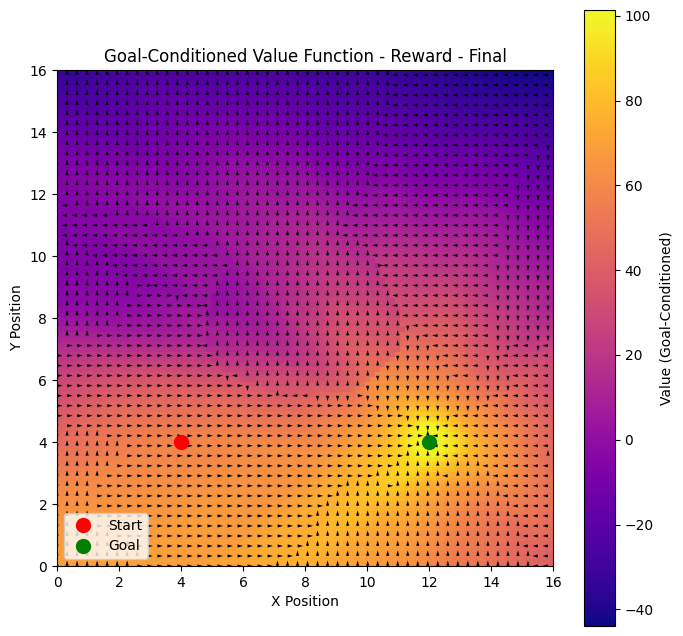

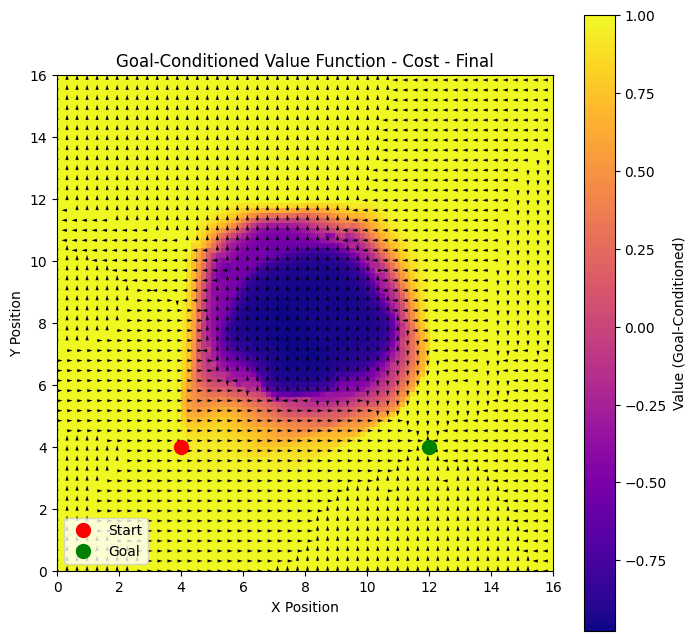

In [50]:
from task_aware_skill_composition.brax.agents.hdcqn_automaton_her import networks as hdcq_networks
from task_aware_skill_composition.visualization.critic import make_plots_for_hdcqn_aut

plot1, plot2 = make_plots_for_hdcqn_aut(
        aut_goal_cmdp,
        make_option_policy,
        # make_test_policy,
        hdcq_aut_network,
        params,
        "Final",
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(jnp.array([4., 12., 0., 0., 1.]))),
        save_and_close=False,
        seed=0,
)

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Goal-Conditioned Value Function - Reward - Final'}, xlabel='X Position', ylabel='Y Position'>)

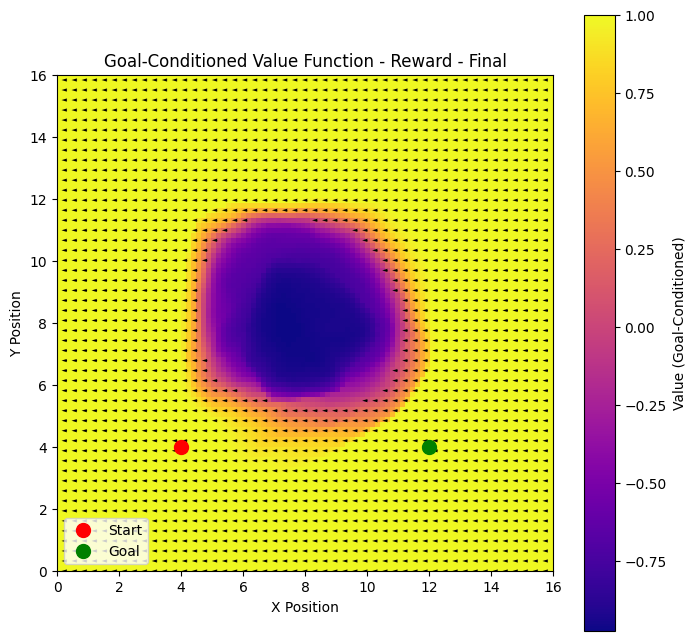

In [49]:
from task_aware_skill_composition.visualization.critic import make_plots_for_forbidden_actions

make_plots_for_forbidden_actions(
        aut_goal_cmdp,
        task.hdcqn_her_hps["safety_minimum"],
        make_test_option_policy,
        hdcq_aut_network,
        params,
        "Final",
        # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:6].set(jnp.array([12., 12.]))),
        save_and_close=False,
)   

In [ ]:
from task_aware_skill_composition.brax.agents.hdcqn_automaton_her import networks as hdcqn_automaton_her
from task_aware_skill_composition.visualization.critic import make_plots_for_hdcqn
from brax.training.acme import running_statistics

tmp_env = make_aut_goal_cmdp(task)
seed=0

# normalize = lambda x, y: x
normalize = running_statistics.normalize

hdcq_network = hdcqn_automaton_her.make_hdcq_networks(
      env.observation_size,
      env.goalless_observation_size,
      env.action_size,
      options=options,
      preprocess_observations_fn=normalize,
)
make_policy = hdcq_networks.make_option_inference_fn(hdcq_network, task.hdcqn_her_hps["cost_budget"])

plot1, plot2 = make_plots_for_hdcqn(
        tmp_env,
        make_policy,
        hdcq_network,
        params,
        0,
)

# Visualizing HDQN Q Function

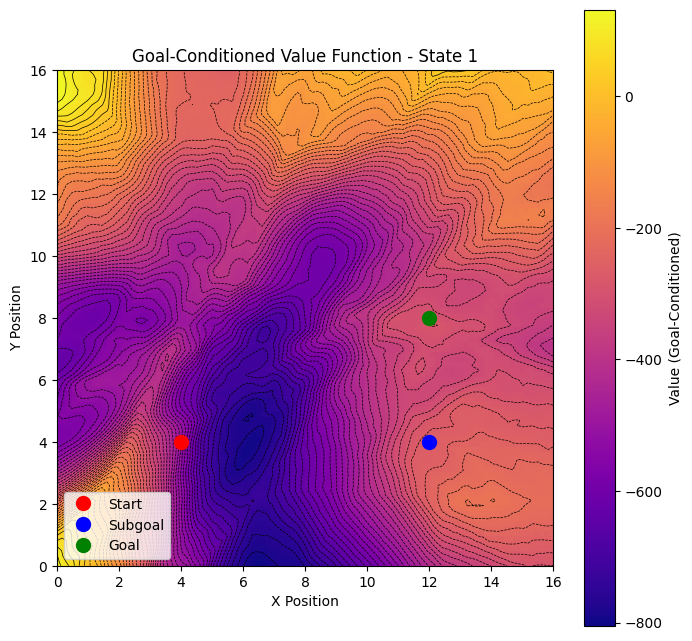

In [64]:
from task_aware_skill_composition.brax.agents.hdqn import networks as hdq_networks
from task_aware_skill_composition.visualization.critic import make_plots_for_hdqn
from task_aware_skill_composition.brax.training.acme import running_statistics

# normalize = lambda x, y: x
# normalize = running_statistics.normalize
# normalize = functools.partial(running_statistics.normalize, mask=normalization_mask)

tmp_env = make_aut_goal_mdp(task)
seed=0

plot1 = make_plots_for_hdqn(
        tmp_env,
        hdq_aut_network,
        params,
        "State 1",
        seed=seed,
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:6].set(jnp.array([12., 8.]))),
        save_and_close=False,
)

# state_zero_suffix = jnp.concatenate((jnp.array([4.0, 12.0]), tmp_env.automaton.one_hot_encode(jnp.int32(1))))
# state_zero_suffix = jnp.array([4.0, 12.0])

# plot2 = make_plots_for_hdqn(
#         tmp_env,
#         hdq_aut_network,
#         params,
#         "State 0",
#         seed=seed,
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[:6].get()),
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[4:].set(state_zero_suffix)),
#         # tmp_state_fn=lambda x: x.replace(obs=x.obs.at[8:].set(tmp_env.automaton.one_hot_encode(jnp.int32(0)))),
#         save_and_close=False,
# )

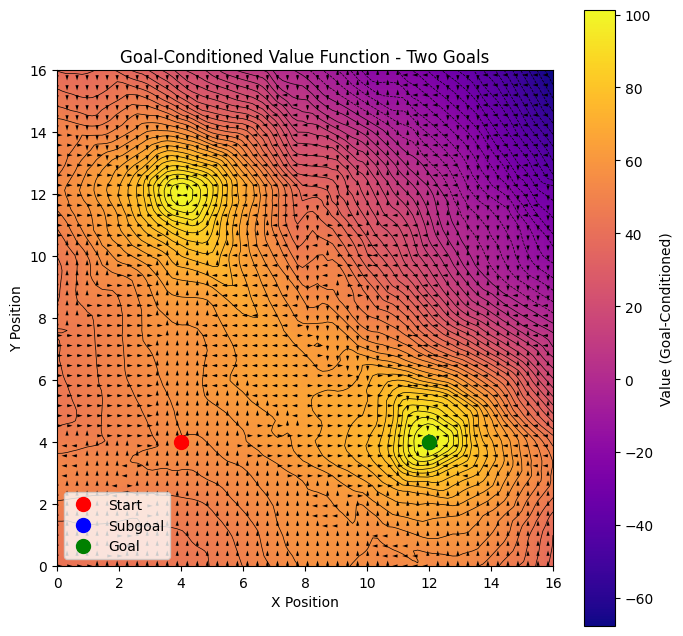

In [24]:
from task_aware_skill_composition.visualization.critic import make_test_plot_for_hdqn

plot1 = make_test_plot_for_hdqn(
        tmp_env,
        hdq_network,
        params,
        "Two Goals",
        seed=seed,
        save_and_close=False,
)

# Visualize Q Function 3

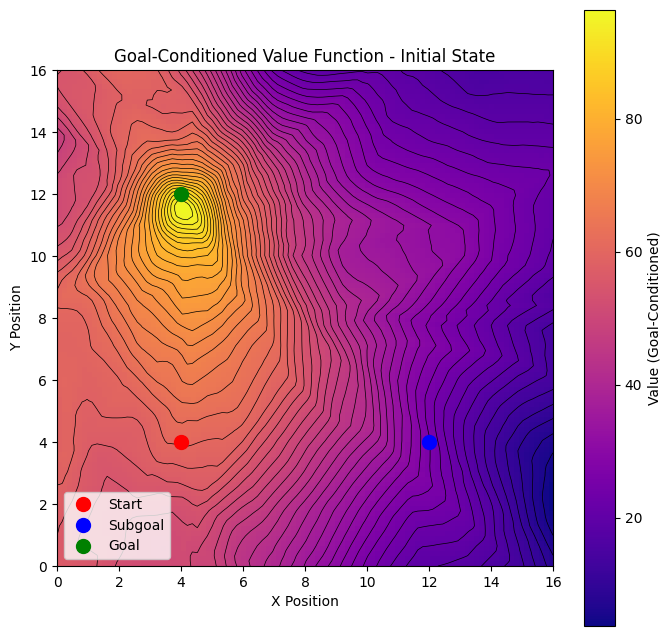

In [29]:
from task_aware_skill_composition.visualization.critic import make_plots_for_hdqn
from task_aware_skill_composition.brax.training.acme import running_statistics

seed=0

plot1 = make_plots_for_hdqn(
        aut_goal_mdp,
        hdq_aut_network,
        params,
        "Initial State",
        seed=seed,
        tmp_state_fn=lambda x: x.replace(obs=x.obs.at[-3:].set(jnp.array([2, 4, 12]))),
        save_and_close=False,
)